# DengAI
This project comes from the challenge proposed by [DRIVENDATA](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/). The goal consists of predicting how many dengue fever cases occur in two different cities. In order to do so, they provide a set of standard features that include aspects such as temperature, level of vegetation, etc.

It is important to state that since our intention is to predict the number of cases this is a regression problem. However, if we quantize the ```y``` labels we might also consider a classification problem, although we leave such task for another analysis.

## Reading data

In [3]:
import pandas as pd
import os
import numpy as np

def read_data(data_file):
    data_structure = pd.read_csv(os.path.join('data',data_file))
    return data_structure

features = read_data('dengue_features_train.csv');
labels = read_data('dengue_labels_train.csv');
print('Training data readed!')

# We mix features and labels in a single dataset for commodity
features['total_cases']=labels['total_cases']
# Number of cities
print('Cities: {}'.format(features.city.unique()))


Training data readed!
Cities: ['sj' 'iq']


In order to grasp the dataset we focus on one of the cities. Then, we can replicate our analyses with the other one.

In [4]:
# We split data for the two cities
#city_data = features[features['city'] == 'sj']
city_data = features[features['city'] == 'iq']


# Data imputation
We check out how many of the features are missing (NaN) columnwise. It is important to appoint such values, since models might be affected by those points.

In [5]:
missing = {}
for col in city_data:
    missing_no = city_data[col].isna().sum()
    if missing_no != 0:
        missing[col] = missing_no;

pd.DataFrame(missing.values(), index = missing.keys(), columns=['Number of missing elements'])

,Number of missing elements
ndvi_ne,3
ndvi_nw,3
ndvi_se,3
ndvi_sw,3
precipitation_amt_mm,4
reanalysis_air_temp_k,4
reanalysis_avg_temp_k,4
reanalysis_dew_point_temp_k,4
reanalysis_max_air_temp_k,4
reanalysis_min_air_temp_k,4


We observe that some of these could be estimated using alternative features. That is hte example of "station_avg_temp_c", which could be estimated using "station_max_temp_c" and "station_min_temp_c" if they existed. Same could happen with "reanalysis_avg_temp_k". 

Nevertheless, since we are working with temporal series data it seems reasonable enough to interpolate the missing values using the data that we already know. This might be effective if the missing values are sparsely distributed.

In [6]:
for col in missing.keys():
    city_data[col].interpolate(inplace=True)

/home/osthaton/anaconda2/envs/py3/lib/python3.8/site-packages/pandas/core/generic.py:7023: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


# New features

We infer some features that might be interesting: 
* ```day``` 
* ```month``` 

using ```week_start_date```. We remove the latter, and also ```city``` since we will perform our regression considering each city separatedly.



In [7]:
city_data['month'] = city_data.apply(lambda x: int(x['week_start_date'][5:7]), axis=1);
city_data['day'] = city_data.apply(lambda x: int(x['week_start_date'][8:10]), axis=1);
city_data.pop('week_start_date');
city_data.pop('city');

# city_data['inverse_year'] = city_data['year'].apply(lambda x: 1/x);


<ipython-input-7-b1320e8b2503>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['month'] = city_data.apply(lambda x: int(x['week_start_date'][5:7]), axis=1);
<ipython-input-7-b1320e8b2503>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['day'] = city_data.apply(lambda x: int(x['week_start_date'][8:10]), axis=1);


We include a feature that might be interesting, which is the ```season```. Considering that there are four seasons (spring, summer, autumn, winter), we provide a numerical label for each one of them. The underlying idea is that depending on the month, we will code a new feature indicating the season under analysis. This is clearly a periodic feature, which is potentially relatable with the number ```total_cases```.

![Image](https://images.theconversation.com/files/253677/original/file-20190114-43517-11n11cr.jpg?ixlib=rb-1.1.0&rect=149%2C4%2C2318%2C1580&q=45&auto=format&w=496&fit=clip)

In [8]:
# We define the four seasons from the North hemishpere. 
def season(input_data):
    input_data = int(input_data)
    if (input_data >=1) & (input_data <=3): # Winter        
        output = 4;        
    if (input_data >=4) & (input_data <=6): # Spring        
        output = 1;
    if (input_data >=7) & (input_data <=9): # Summer        
        output = 2;
    if (input_data >=10) & (input_data <=12): # Autumn/Fall        
        output = 3;
    return output

city_data['season'] = city_data['month'].apply(season);



<ipython-input-8-8b7089fa2bd3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['season'] = city_data['month'].apply(season);


We also design a function that allows us to include a certain context. That is, our features would be formed not only by current data (in a certain time ```t```), but also by previous values (```t-1```, ```t-2```, etc.). However, we don't make extensive use of this function for now.

In [9]:
def context_extractor(data_structure):
    alt_data_structure = data_structure[:];
    
    col_names = [i for i in data_structure.columns  if i not in ['total_cases','total_cases_LOG','diff','pos_neg']]
    lag = 1;
    col_names_lag = [i+'_'+str(lag) for i in col_names]
    
    alt_data_structure[col_names_lag] = city_data[col_names]
    alt_data_structure['weekofyear_1'] = alt_data_structure['weekofyear_1'].shift(1)

            
    return alt_data_structure


# Studying correlation
It is quite important to understand what is the correlation between our existing features. An interesting fact is that correlation allows to measure some degree of similarity in a linear way, which means that two features that show a big value of such score can be linearly obtained from each other. This means that using features with a significant degree of correlation might worsen the performance of a model, since we would be feeding it using data that is redundant. Consequently, we need to minimize the number of features that are strongly correlated.

On the contrary, features that are highly correlated with the labels, denoted ```total_cases```, are highly desirable since they can be helpful to make our predictions.

In [12]:
# We study each feature independently and how it relates with the rest
from DengAI_utils import compute_correlation
correlation_matrix = compute_correlation(city_data);

We can observe that some of the features are strongly correlated, as it happens with ```ndvi_``` features and ```reanalysis_air_temp_k``` and ```reanalysis_avg_temp_k```.

If we focus on the correlation between ```total_cases``` and our feature-set we obtain the following graph, which depicts that for the ```city=iq``` the top features are ```season```, a humidity variable and three temperature variables. Notice that these will change for ```city=sj```.

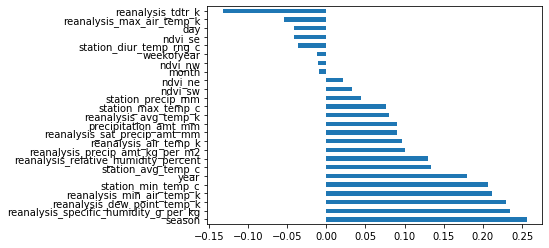

In [13]:
correlation_matrix.total_cases.drop('total_cases').sort_values(ascending=False).plot.barh();

We can get a ranking with such scores and use it later to train our model.

In [14]:
sorted_features = correlation_matrix.total_cases.drop('total_cases').sort_values(ascending=False)
sorted_features[:7]

season                                   0.256320
reanalysis_specific_humidity_g_per_kg    0.235218
reanalysis_dew_point_temp_k              0.229183
reanalysis_min_air_temp_k                0.211679
station_min_temp_c                       0.206817
year                                     0.179451
station_avg_temp_c                       0.133989
Name: total_cases, dtype: float64

# Poly features
Alternative features can be computed using polynomic functions. We select some of the features and attempt to extract a new set using their polynomic combinations.

In [19]:
selected_features = ['weekofyear','month','inverse_year','reanalysis_specific_humidity_g_per_kg','reanalysis_dew_point_temp_k','station_avg_temp_c','reanalysis_max_air_temp_k']
from ML_utils.FeatureExtraction import FeatureExtraction
feature_extractor = FeatureExtraction();
feature_extractor.polynomial(9);
feature_extractor.fit(city_data[[i for i in city_data.columns if i in selected_features]])
poly_feat = pd.DataFrame(feature_extractor.transform(city_data[[i for i in city_data.columns if i in selected_features]], 'poly'))

poly_feat['total_cases'] = city_data['total_cases']
sorted_features = (poly_feat.corr()
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False))
poly_selection = sorted_features[:1].keys()

In [20]:
n_poly = 1;
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
aux = scaler.fit_transform( poly_feat[sorted_features[:n_poly].keys()])

for i in range(n_poly):
    city_data['poly_{}'.format(i)] = aux[:,i]

<ipython-input-20-83aa42b17f40>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['poly_{}'.format(i)] = aux[:,i]


In the city we are analysing, it seems that ```poly_0``` is working reasonably well. Notice that such polynomia was computed after studying different combinations until the 9th degree.

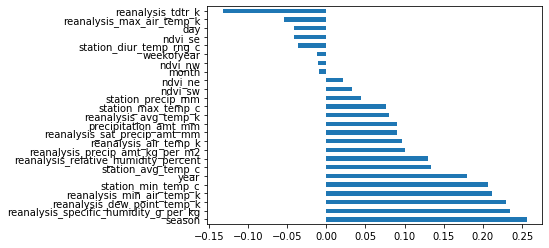

In [23]:
# This interesting
(correlation_matrix
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

In [24]:
# This interesting
n_features = 10;
top_features = (correlation_matrix
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False))[0:n_features]
top_features.keys()

Index(['season', 'reanalysis_specific_humidity_g_per_kg',
       'reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'year', 'station_avg_temp_c',
       'reanalysis_relative_humidity_percent',
       'reanalysis_precip_amt_kg_per_m2', 'reanalysis_air_temp_k'],
      dtype='object')